# Visualize Simulated Boycott Results

In [539]:
from collections import defaultdict
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark")
from scipy import stats

from scipy.interpolate import interp1d

NUM_USERS = 6040

First things first: let's load our master data file (a single, aggregated csv)
and take a glance at the data.

In [540]:
# old_df = pd.read_csv('all_results_v01.csv', dtype={'indices': str})
df = pd.read_csv('all_results.csv', dtype={'indices': str})
print(len(df.index))
df = df[df.ratingfrac.notna()]
print(len(df.index))

13170
7360


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [551]:
df = df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in df.num_users])

# drop columns we're not going to use.
drops = [
    'tail',
]
for column in df.columns.values:
    for drop in drops:
        if drop in column:
            df = df.drop(column, axis=1)

# old_df = old_df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in old_df.num_users])

Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [552]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    # 'tailndcg10',
    # 'ndcgfull',
    'prec10t4',
    # 'tailprec10t4',
]
organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre',
    'genre_strict',
]
algo_names = [
    'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = ['KNNBaseline_item_msd', 'SVD', 'GlobalMean', 'MovieMean', 'GuessThree']
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)

for algo_name in standard_algo_names:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        'ml-1m', algo_name)
    with open(filename_ratingcv_standards, 'r') as f:
        standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name].get(metric, 0)
        print('goodval', goodval)
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'].get(metric, 0)
        guess_three = standard_results['GuessThree'][metric]
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100 if goodval else 0
print('global', algo_to_metric_vs_global_mean)
print('movie', algo_to_metric_vs_movie_mean)
print('guess3', algo_to_metric_vs_guess_three)

goodval 0.8854826539625993
goodval 0.7917576771996123
goodval 0.7992590656809996
goodval 0.8738937258268422
goodval 0.7934699275627399
goodval 0.8035561666164517
global defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 26.15726262789976, 'ndcg10': -25.206712008386738, 'prec10t4': -21.453008326226954}, 'SVD': {'rmse': 27.83026634355781, 'ndcg10': -25.368110481189, 'prec10t4': -21.87304660783151}})
movie defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.605923858493796, 'ndcg10': -2.316653111465638, 'prec10t4': -1.7330414237136504}, 'SVD': {'rmse': 12.072697294556987, 'ndcg10': -2.527446665665193, 'prec10t4': -2.258534297970622}})
guess3 defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 42.22942488810704, 'ndcg10': -25.300454148662105, 'prec10t4': -21.19621127706749}, 'SVD': {'rmse': 44.11556565683586, 'ndcg10': -25.461650332747237, 'prec10t4': -21.617622807843677}})


In [553]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)

In [554]:
samples_df = df[df['type'] == 'sample_users']
if not samples_df.empty:
    print(samples_df[['name', 'num_users', 'num_users_boycotting']].head())
org_df = df[df['type'].isin(organized_experiments)]

                  name  num_users  num_users_boycotting
4816  1208 user sample       4832                  1208
4818  1208 user sample       4832                  1208
4819  1208 user sample       4832                  1208
4821  1208 user sample       4832                  1208
4822  1208 user sample       4832                  1208


In [555]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error.
This will be an important piece of context for analyzing the experiments.

In [556]:
# for algo_name in algo_names:
#     filt = org_df[org_df.algo_name == algo_name]
#     for metric in metrics:
#         key = 'percent_increase_{}_non-boycott'.format(metric)
#         sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
#         plt.show()
#         slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
#         print(slope, intercept, r_value, p_value)
#         algo_to_metric_to_slope[algo_name][metric] = slope
#         algo_to_metric_to_intercept[algo_name][metric] = intercept
        
#         # calculate the average error for all boycott users in each dataframe
#         algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
#             samples_df[(
#                 (samples_df.algo_name == algo_name) &
#                 (samples_df.userfrac == 1.0) & 
#                 (samples_df.ratingfrac == 1.0)
#             )][key.replace('non-boycott', 'boycott')]
#         )

In [557]:
def select_cols(cols, metrics, groups, percents):
    """take a list of cols and filter based on metrics/groups/percents"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [558]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [565]:
def p_b_curve(df, metrics, groups, percents=False, lm_plot=True, reg_plot=False):
    algo_to_metric_to_interp = defaultdict(dict)
    if lm_plot:
        increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
        longform = df[increase_cols + id_vars].melt(
            id_vars = id_vars,
            var_name='increase_type'
        )
        longform = fill_in_longform(longform)
        
        grid = sns.lmplot(
            x="num_users_boycotting", y="value", hue="group", data=longform,
            sharey='row', sharex='col',
            size=10, row='metric', col='algo_name',
            fit_reg=False,
            x_estimator=np.mean, ci=99,
        )
        # CALC LOG PLOT
#         vals = [float(x) for x in list(longform.value)]
#         minval = np.min(vals)
#         shifted = vals + - minval + 0.00001
#         print(np.min(shifted))
#         longform = longform.assign(logy = np.log2(shifted))
#         g = sns.lmplot(
#             x="num_users_boycotting", y="logy", hue="algo_name", data=longform,
#             size=6, row='metric',
#             x_estimator=np.mean,
#             order=2
#         )
    
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            key = 'increase_{}_non-boycott'.format(metric)
            if percents:
                key = 'percent_' + key
            x = filt.num_users_boycotting
            user_nums = list(set(filt.num_users_boycotting))
            y = filt[key]
            
            num_to_mean = {}
            for num_users_boycotting in user_nums:
                filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
            meany = np.array(list(num_to_mean.values()))
            
            smoothf = interp1d(user_nums, meany, kind='quadratic', bounds_error=False, fill_value='extrapolate')
            algo_to_metric_to_interp[algo_name][metric] = smoothf
            xnew = np.linspace(min(user_nums), max(user_nums), num=500)
            if reg_plot:
                _, ax = plt.subplots()
                g = sns.regplot(
                    x=x, y=y,
                    x_estimator=np.mean,
                    x_bins=user_nums,
                    ax=ax,
                    ci=99,
                    fit_reg=False,
                )
                g.set_title(algo_name)
                
                plt.plot(xnew, smoothf(xnew), '-')
                plt.axhline(0, color='0.5', linestyle='--')
                plt.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        if group != 'non-boycott':
            continue
        # flag. 
        ax = grid.axes[i_row, i_col]
        ax.plot(xnew, algo_to_metric_to_interp[algo_name][metric](xnew), '-', color=grid._colors[i_hue])
        ax.axhline(0, color='0.5', linestyle='--')
        ax.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
    plt.subplots_adjust(hspace=0.3)
#     for metric in metrics:
#         for algo_name in algo_names

    return algo_to_metric_to_interp


Working through log plots
y = log(x)
y = e ^ x
ln(y) = x

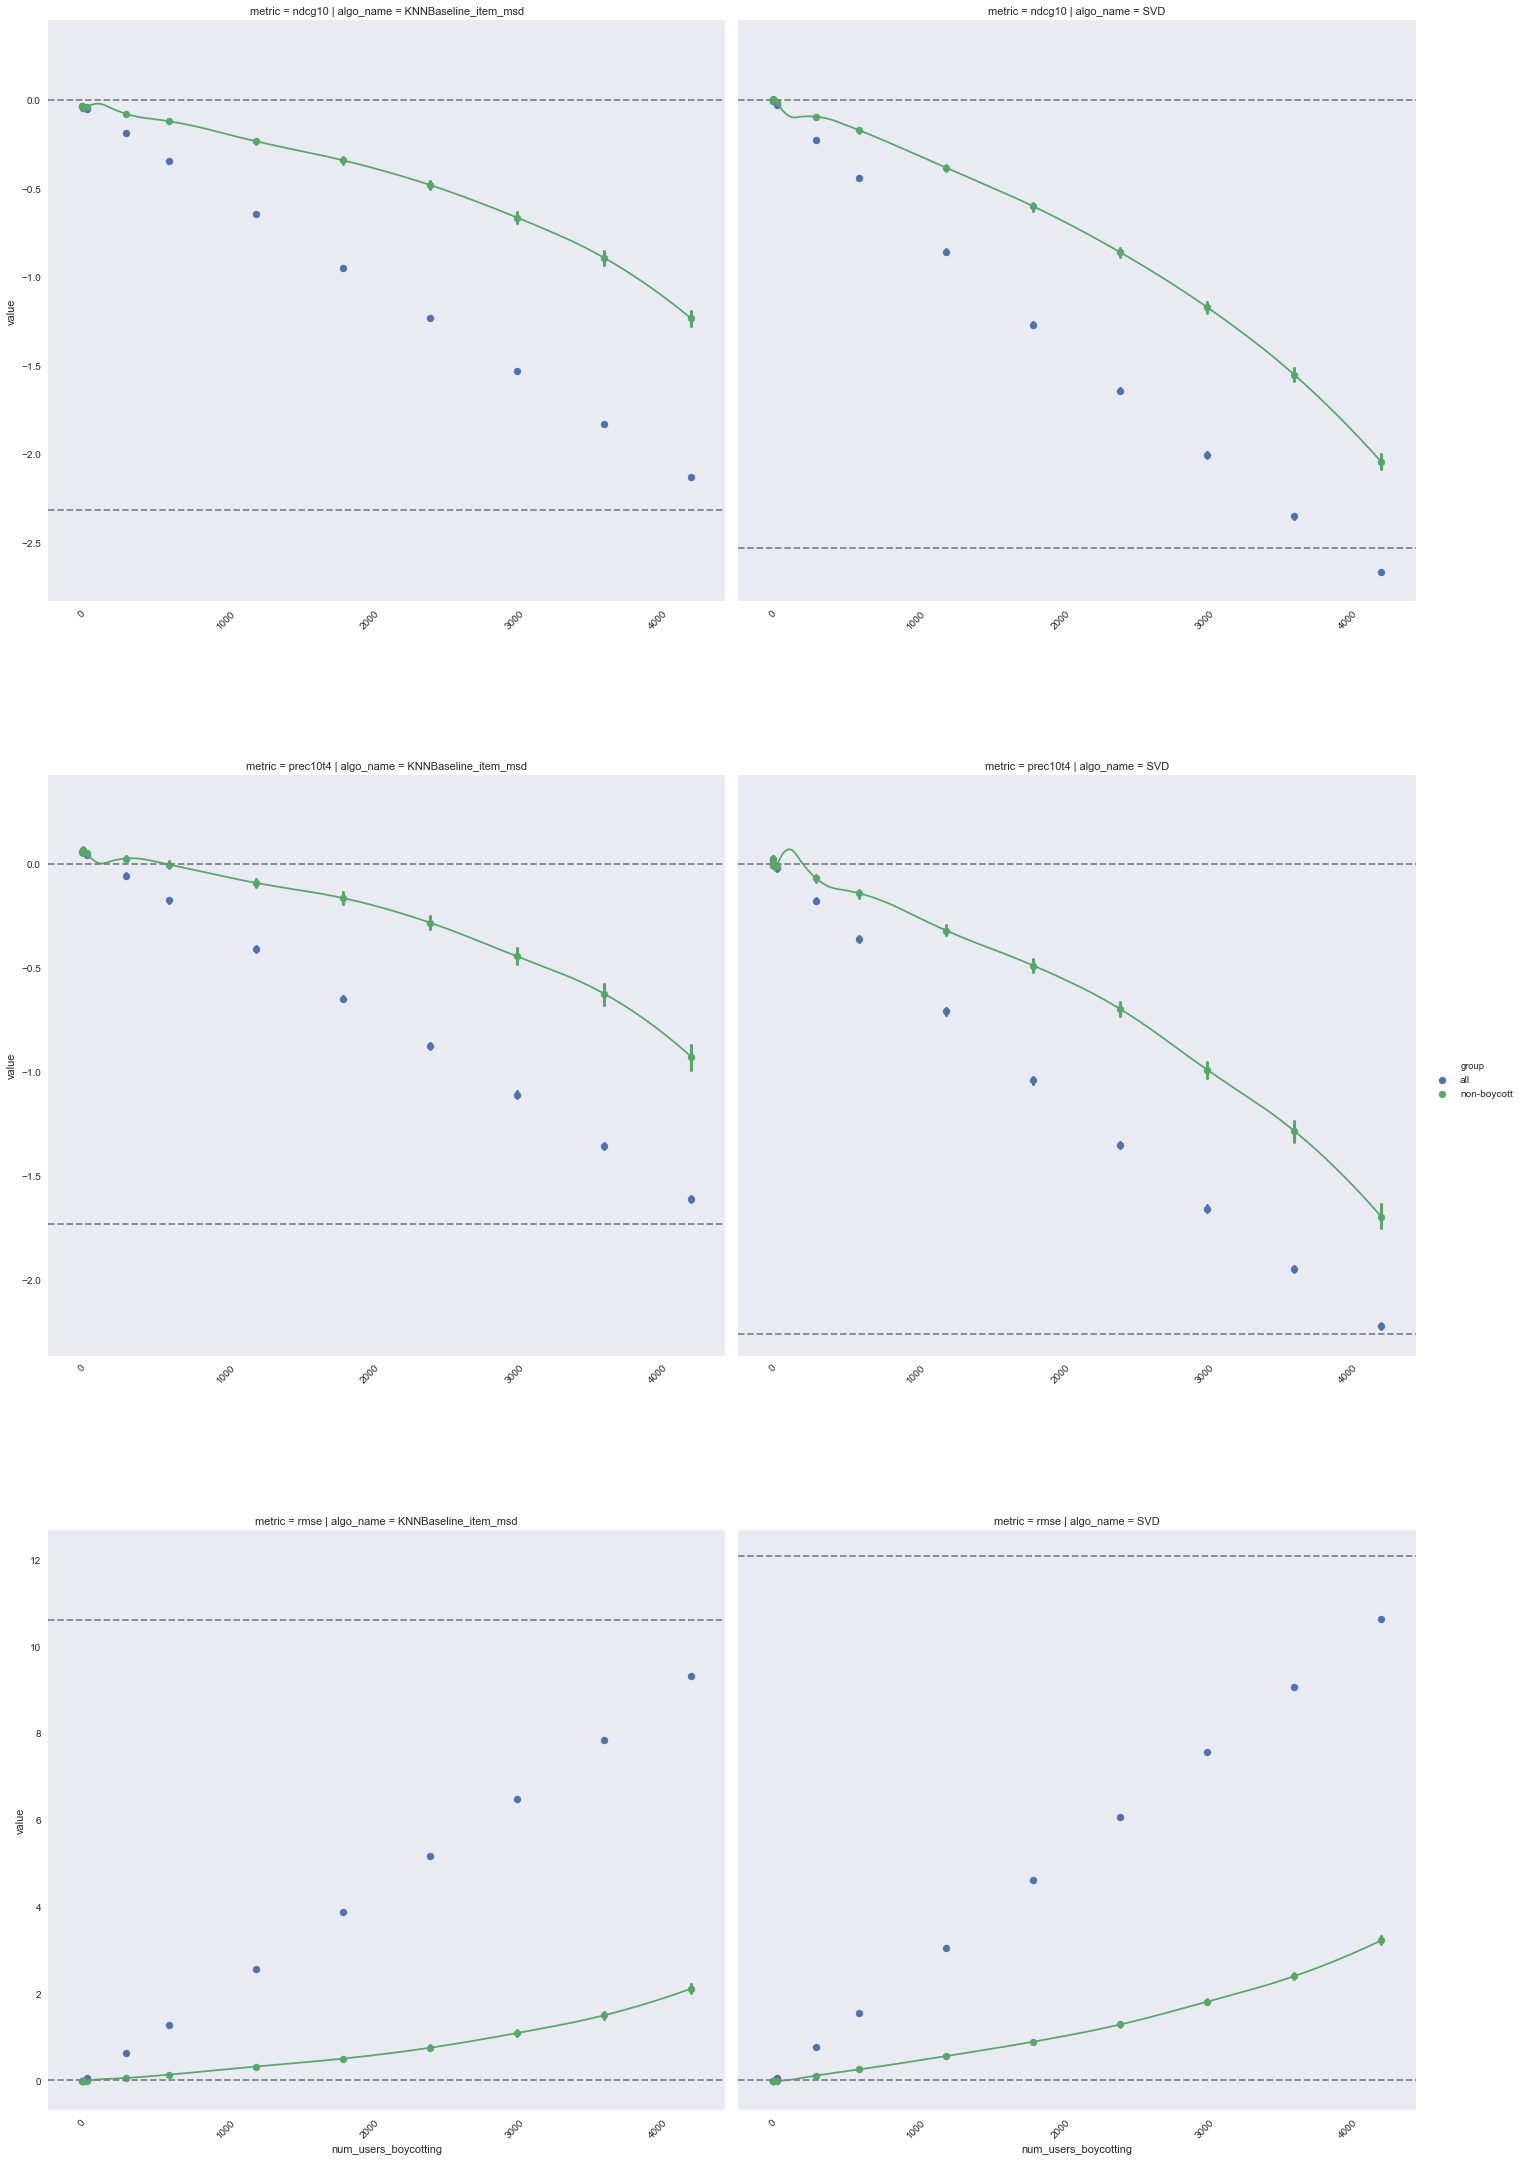

In [566]:
algo_to_metric_to_interp = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all', ]
)
plt.show()

In [567]:
for metric in metrics:
    for algo_name in algo_names:
        key = 'percent_increase_{}_expected'.format(metric)
        expected_vals = algo_to_metric_to_interp[algo_name][metric](org_df.num_users_boycotting)
        print(key)
        kwargs = {key: expected_vals}
        org_df = org_df.assign(**kwargs)

percent_increase_rmse_expected
percent_increase_rmse_expected
percent_increase_ndcg10_expected
percent_increase_ndcg10_expected
percent_increase_prec10t4_expected
percent_increase_prec10t4_expected


In [ ]:
algo_to_metric_vs_movie_mean

In [ ]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name_plus_ratings=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    grid = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        # linestyles='None',
        # capsize=0.1
    )
    a = grid.axes
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]
        val = algo_to_metric_vs_movie_mean[algo_name].get(metric, 0)
        grid.axes[i_row, i_col].axvline(0, color='0.5', linestyle='--')
        grid.axes[i_row, i_col].axvline(val, color='0.5', linestyle='--')
    return grid


In [ ]:
state_boycotts = org_df[org_df['type'] == 'state']
gender_boycotts = org_df[org_df['type'] == 'gender']
age_boycotts = org_df[org_df['type'] == 'age']
occupation_boycotts = org_df[org_df['type'] == 'occupation']
power_boycotts = org_df[org_df['type'] == 'power']
genre_boycotts = org_df[org_df['type'] == 'genre']
genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']
print(genre_strict_boycotts)

In [ ]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [ ]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0)
    )]

In [ ]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [ ]:
def plot_all_three_scenarios(df, size=6):
    all_df = all_users_all_ratings(df)
    if not all_df.empty:
        plot2(
            all_users_all_ratings(df),
            metrics=metrics,
            percents=True,
            groups=['all', 'non-boycott', 'expected'],
            size=size
        ).fig.suptitle('All Users, All Ratings')
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['all', 'non-boycott', 'like-boycott', 'expected'],
            size=size
        ).fig.suptitle('Half Users')
        
    half_ratings_df = half_ratings(df)
    if not half_ratings_df.empty:
        plot2(
            half_ratings_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
            size=size,
        ).fig.suptitle('Half Ratings')
    plt.show()

## Let's do gender first...

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


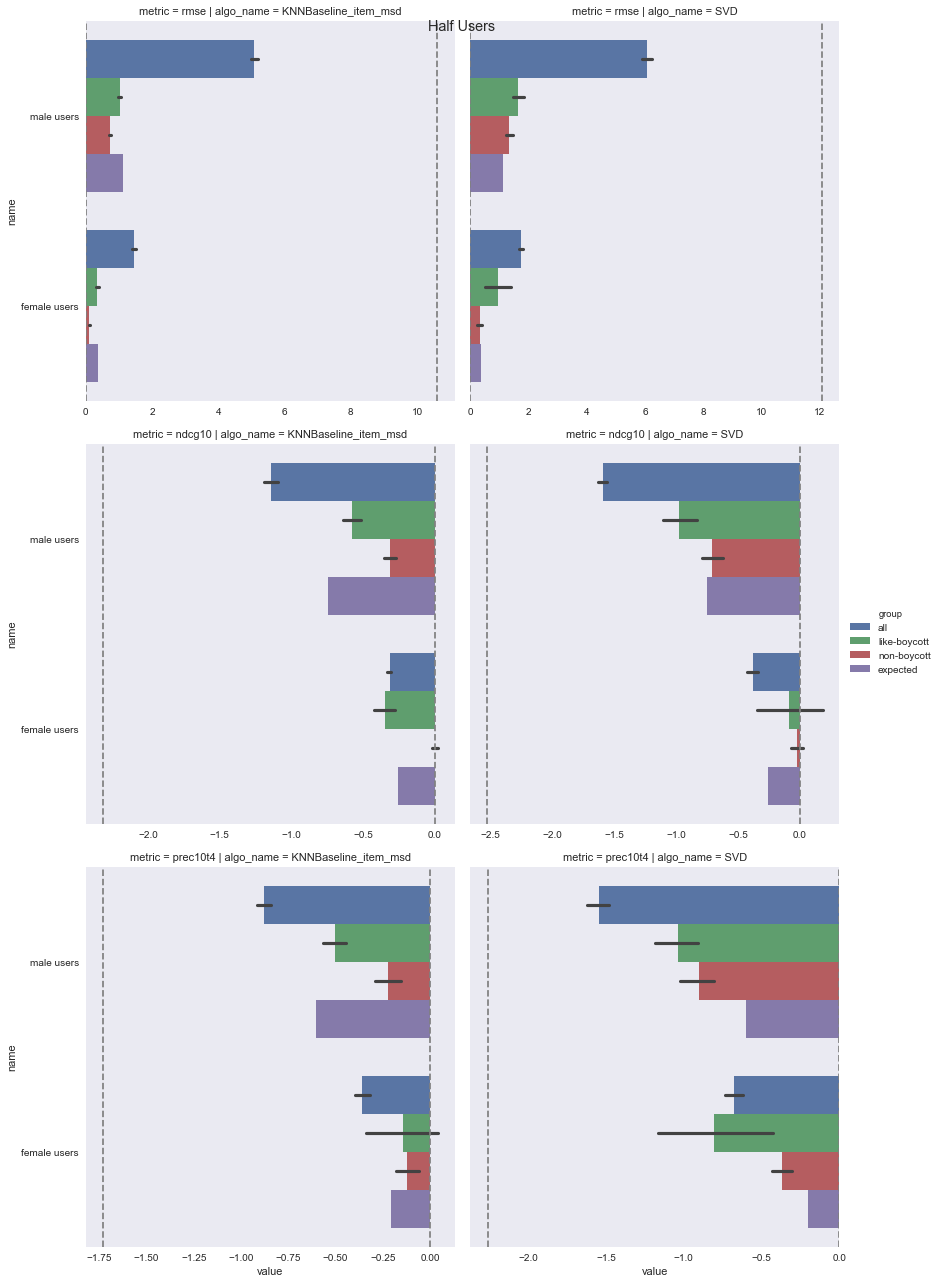

In [568]:
plot_all_three_scenarios(gender_boycotts)

States seemed uninteresting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

In [ ]:
# plot_all_three_scenarios(state_boycotts, size=12)

Below, the power boycotts show a very weird results. Warrants double checks.

It appears for KNN, removing all power users actually improves performance (as opposed to the large expected drop).
But at the same time, RMSE increases! This is one of the example where RMSE and NDCG do not correlate...

Note the artifact in plot #5 below: it looks like ndcg has a huge increase when bottom 10% users do a half boycott... but this is b/c ndcg@10 is just getting easier to "succeed" for these users

In [ ]:
plot_all_three_scenarios(power_boycotts)

In [ ]:
plot_all_three_scenarios(age_boycotts)

In [ ]:
plot_all_three_scenarios(occupation_boycotts, size=10)

In [ ]:
plot_all_three_scenarios(genre_boycotts, size=10)

In [ ]:
plot_all_three_scenarios(genre_strict_boycotts, size=10)

### Looking at our real numbers
Full dataset precision@10 is 
SVD: 0.8026069529047541
KNN: 0.7999920231446164
w/ 3000 users boycotting:
KNN: 0.785440336
SVD: 0.784764938

In [ ]:
prec_w_0 = {
    'SVD': 0.8026069529047541,
    'KNN': 0.7999920231446164
}
prec_w_3000 = {
    'SVD': 0.784764938,
    'KNN': 0.785440336
}

In [ ]:
for n in ('SVD', 'KNN'):
    old = prec_w_0[n]
    new = prec_w_3000[n]
    err_rate_old = (1 - old) * 10
    err_rate_new = (1 - new) * 10
    delta = err_rate_new - err_rate_old
    print('err rate old vs new:', err_rate_old, err_rate_new, err_rate_new / err_rate_old)
    print('% change err rate', delta / err_rate_old * 100)
    percent_change = (new - old) / old * 100
    raw_change = new - old
    print(percent_change, '%', raw_change, 'raw')
    err_per_user = raw_change * 10
    print(err_per_user / err_rate_old * 100)
    
    err_per_1m = err_per_user * 1e6
    users_needed_to_see_err = 1 / err_per_user
    print('Error per user:', err_per_user)
    print('Error per 1m users:', err_per_1m)
    print(users_needed_to_see_err, 'users')